In [113]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import Aer
from qiskit.visualization import plot_histogram, plot_state_city, plot_circuit_layout
from math import pi
%matplotlib inline
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend_sim = Aer.get_backend('qasm_simulator')
backend_exp = provider.get_backend('ibmqx2')
sh=1024
y_exp=np.array([])
y_sim=np.array([])
x=np.arange(0,17*pi/(4*3),pi/(4*3))
x_th=np.arange(0,4*np.pi/3,0.01) 
y_th=((np.cos(x_th*3))+1)/2

In [19]:
def BeamS(q,qr,c,cr,f):
    circ=QuantumCircuit(qr,cr)
    for i in range(q-1):
        circ.cx(0,i+1)
    circ.h(0)
    for i in range(q-1):
        circ.cx(0,i+1)
    circ=f+circ
    return circ

In [3]:
def measu(qr,cr,f):
    meas=QuantumCircuit(qr,cr)
    meas.barrier(qr[:])
    meas.measure(qr[:],cr[:])
    qc=f+meas
    return qc

In [4]:
def phase(q,qr,c,cr,ph,f):
    circ=QuantumCircuit(qr,cr)
    for i in range(q):
        circ.u1(ph,i)
    return f+circ

In [5]:
#Create circuit
q=3
c=3
qr=QuantumRegister(q)
cr=ClassicalRegister(c)
MZ=QuantumCircuit(qr,cr)
#initialize state
#vec=np.zeros(2**q)
#vec[(2**q)-1]=1  
#MZ.initialize(vec, [qr[:]])
#BeamSplitter
MZ=BeamS(q,qr,c,cr,MZ)
#phase
MZ=phase(q,qr,c,cr,pi/(2*5),MZ)
#BeamSplitter
MZ=BeamS(q,qr,c,cr,MZ)
#measurements
MZ=measu(qr,cr,MZ)


MZ.draw()

In [6]:
def MZI(q,qr,c,cr,ph):
    MZ=QuantumCircuit(qr,cr)
    #initialize state
    #vec=np.zeros(2**q)
    #vec[(2**q)-1]=1  
    #MZ.initialize(vec, [qr[:]])
    #BeamSplitter
    MZ=BeamS(q,qr,c,cr,MZ)
    #phase
    MZ=phase(q,qr,c,cr,ph,MZ)
    #BeamSplitter
    MZ=BeamS(q,qr,c,cr,MZ)
    #measurements
    MZ=measu(qr,cr,MZ)
    return MZ

In [7]:
q=3
c=3
qr=QuantumRegister(q)
cr=ClassicalRegister(c)
Mz=MZI(q,qr,c,cr,(pi/(4*5)))
Mz.draw()

In [141]:
#simulating every circuit
circuits=[]
for i in range(len(x)):
    q=3
    c=3
    qr=QuantumRegister(q)
    cr=ClassicalRegister(c)
    MZ=MZI(q,qr,c,cr,x[i])
    circuits.append(MZ)
    
job_sim=execute(circuits,backend=backend_sim, shots=sh)
result_sim=job_sim.result()

y_sim=np.array([])
    
for i in range(len(x)):
    counts_sim=result_sim.get_counts(circuits[i])
    try:
        counts_sim['000']
    except KeyError:
         y_sim=np.append(y_sim,[0])
    else:
        y_sim=np.append(y_sim,[counts_sim['000']/sh])
        
y_sim
    


array([1.        , 0.84277344, 0.48730469, 0.14648438, 0.        ,
       0.16113281, 0.47753906, 0.86621094, 1.        , 0.84570312,
       0.49804688, 0.16113281, 0.        , 0.16894531, 0.53417969,
       0.86425781, 1.        ])

In [142]:
#EXP every circuit
circuits_tp=[]
for i in range(17):
    circuits_tp.append( transpile(circuits[i], backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4]))

print('Depth:', circuits_tp[15].depth())
    

Depth: 12


In [143]:
#job_exp= execute(circuits_tp, backend=backend_exp)
#job_exp.job_id()

'5e87af576b9a6c0018be7168'

In [144]:
#job_exp = backend_exp.retrieve_job('5e87a5a9a2cbba0012b1f6a7') #No first point
job_exp = backend_exp.retrieve_job('5e87af576b9a6c0018be7168')
result_exp=job_exp.result()
y_exp=np.array([])

for i in range(len(x)):
    counts_exp=result_exp.get_counts(i)
    try:
        counts_exp['000']
    except KeyError:
         y_exp=np.append(y_exp,[0])
    else:
        y_exp=np.append(y_exp,[counts_exp['000']/sh])
        
y_exp

array([0.98535156, 0.57324219, 0.23242188, 0.05078125, 0.08984375,
       0.32519531, 0.63671875, 0.82226562, 0.78808594, 0.56542969,
       0.24804688, 0.078125  , 0.09472656, 0.32617188, 0.65332031,
       0.81152344, 0.79589844])

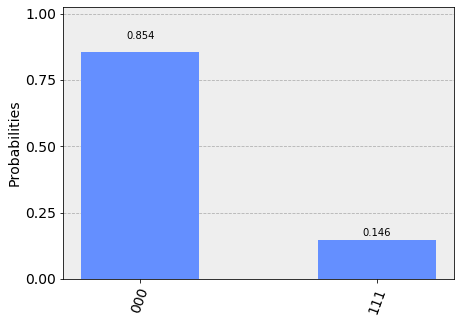

In [43]:
#Sim (Pi/4)
MZ=MZI(q,qr,c,cr,x[1])
job_sim = execute(MZ, backend_sim, shots=sh)
result_sim=job_sim.result()
counts_sim=result_sim.get_counts(MZ)
y_sim=np.append(y_sim,[counts_sim['000']/sh])
plot_histogram(counts_sim)

Depth: 12


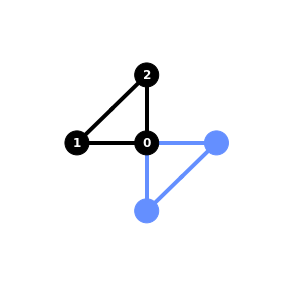

In [25]:
#exp (Pi/4)
MZ_tp = transpile(MZ, backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4])
print('Depth:', MZ_tp.depth())
plot_circuit_layout(MZ_tp, backend_exp)

In [26]:
#exp (Pi/4)
#job_exp= execute(MZ_tp, backend=backend_exp)
#job_exp.job_id()

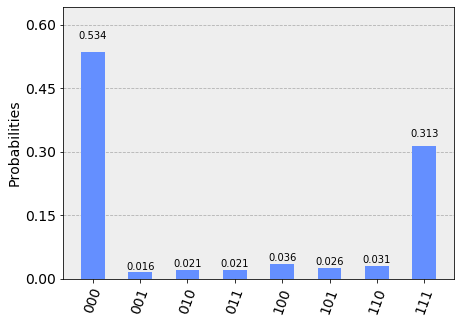

In [27]:
#exp (Pi/4)
job_exp = backend_exp.retrieve_job('5e6a5adce987fe00114c4de5')
result_exp=job_exp.result()
counts=result_exp.get_counts()
y_exp=np.append(y_exp,[counts['000']/sh])
plot_histogram(counts)

In [28]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [29]:
cal_circuits,state_labels=complete_meas_cal(qr=qr, circlabel='measurement_calibration')
cal_circuits[7].draw()

In [30]:
#cal_job=execute(cal_circuits, backend=backend_exp, shots=8192,optimization_level=0)
#cal_job.job_id()

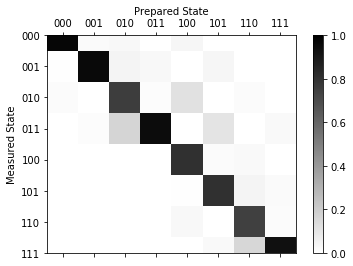

In [31]:
cal_job = backend_exp.retrieve_job('5e6a5b0dd00f3c00112df76a')
cal_results=cal_job.result()
meas_fitter=CompleteMeasFitter(cal_results,state_labels)
meas_fitter.plot_calibration()

In [32]:
meas_filter=meas_fitter.filter

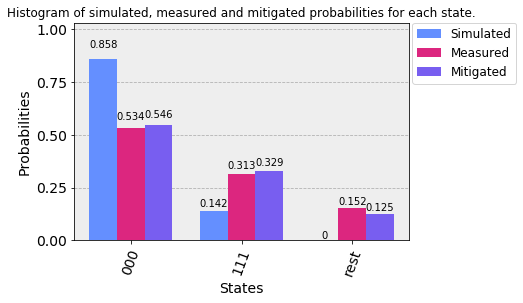

In [69]:
#mitigated exp Pi/4
job_exp = backend_exp.retrieve_job('5e6a5adce987fe00114c4de5')
result_exp=job_exp.result()
mitigated_result=meas_filter.apply(result_exp)
counts=result_exp.get_counts()
mitigated_counts=mitigated_result.get_counts()

fig, ax=plt.subplots()
ax.set_xlabel('States', fontsize=14)
fig=plot_histogram([counts_sim,counts,mitigated_counts],legend=['Simulated','Measured','Mitigated'], number_to_keep=2, title='Histogram of simulated, measured and mitigated probabilities for each state.', ax=ax)
#fig_hist=plot_histogram([counts_sim,counts,mitigated_counts],legend=['Simulated','Real','Mitigated'])
fig

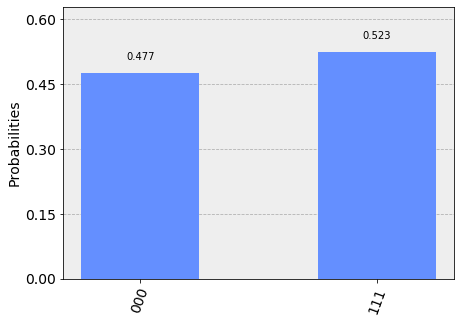

In [13]:
#Sim (Pi/2)
MZ=MZI(q,qr,c,cr,x[2])
job_sim = execute(MZ, backend_sim, shots=sh)
result_sim=job_sim.result()
counts=result_sim.get_counts(MZ)
y_sim=np.append(y_sim,[counts['000']/sh])
plot_histogram(counts)

In [14]:
#exp (Pi/2)
MZ_tp = transpile(MZ, backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4])
#job_exp= execute(MZ_tp, backend=backend_exp)
#job_exp.job_id()

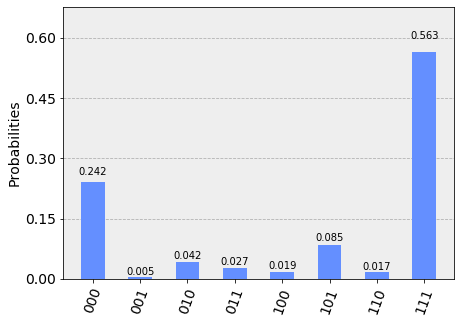

In [15]:
#exp (Pi/2)
job_exp = backend_exp.retrieve_job('5e206b1584b46900184b8d0b')
result_exp=job_exp.result()
counts=result_exp.get_counts()
y_exp=np.append(y_exp,[counts['000']/sh])
plot_histogram(counts)

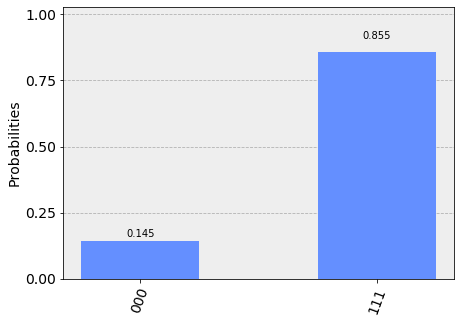

In [16]:
#Sim (3Pi/4)
MZ=MZI(q,qr,c,cr,x[3])
job_sim = execute(MZ, backend_sim, shots=sh)
result_sim=job_sim.result()
counts=result_sim.get_counts(MZ)
y_sim=np.append(y_sim,[counts['000']/sh])
plot_histogram(counts)

In [17]:
#exp (3Pi/4)
MZ_tp = transpile(MZ, backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4])
#job_exp= execute(MZ_tp, backend=backend_exp)
#job_exp.job_id()

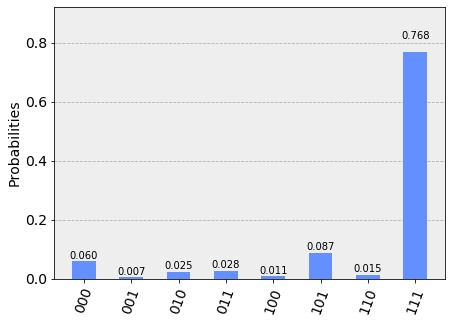

In [18]:
#exp (3Pi/4)
job_exp = backend_exp.retrieve_job('5e206b4384b46900184b8d10')
result_exp=job_exp.result()
counts=result_exp.get_counts()
y_exp=np.append(y_exp,[counts['000']/sh])
plot_histogram(counts)

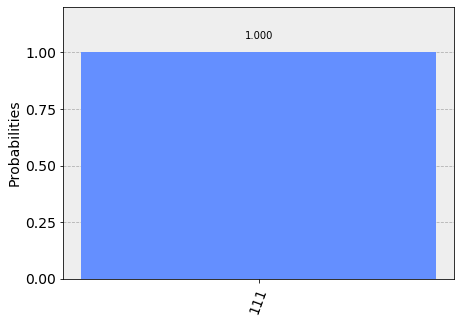

In [19]:
#Sim (Pi)
MZ=MZI(q,qr,c,cr,x[4])
job_sim = execute(MZ, backend_sim, shots=sh)
result_sim=job_sim.result()
counts=result_sim.get_counts(MZ)
y_sim=np.append(y_sim,[0])
plot_histogram(counts)

In [20]:
#exp (Pi)
MZ_tp = transpile(MZ, backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4])
#job_exp= execute(MZ_tp, backend=backend_exp)
#job_exp.job_id()

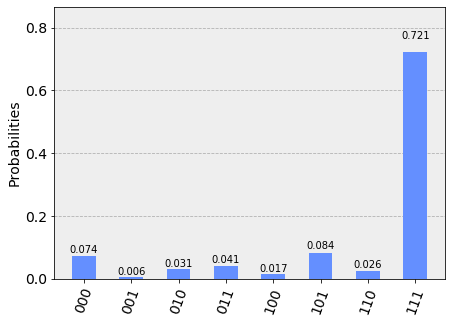

In [21]:
#exp (Pi)
job_exp = backend_exp.retrieve_job('5e206b6104f9320019dab6b6')
result_exp=job_exp.result()
counts=result_exp.get_counts()
y_exp=np.append(y_exp,[counts['000']/sh])
plot_histogram(counts)

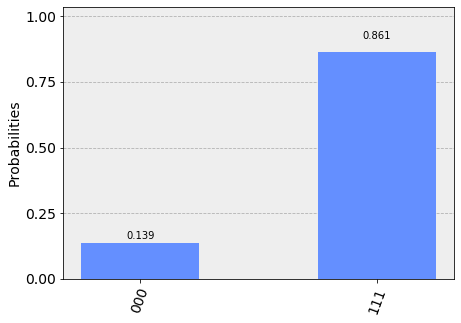

In [22]:
#Sim (5Pi/4)
MZ=MZI(q,qr,c,cr,x[5])
job_sim = execute(MZ, backend_sim, shots=sh)
result_sim=job_sim.result()
counts=result_sim.get_counts(MZ)
y_sim=np.append(y_sim,[counts['000']/sh])
plot_histogram(counts)

In [23]:
#exp (5Pi/4)
MZ_tp = transpile(MZ, backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4])
#job_exp= execute(MZ_tp, backend=backend_exp)
#job_exp.job_id()

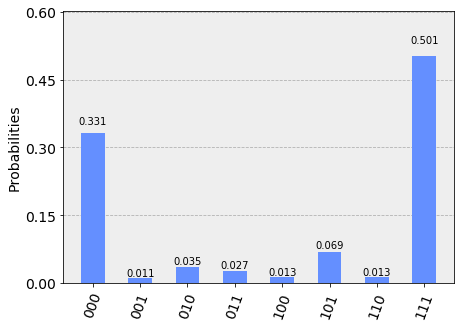

In [24]:
#exp (5Pi/4)
job_exp = backend_exp.retrieve_job('5e206b87c77a86001805b8ff')
result_exp=job_exp.result()
counts=result_exp.get_counts()
y_exp=np.append(y_exp,[counts['000']/sh])
plot_histogram(counts)

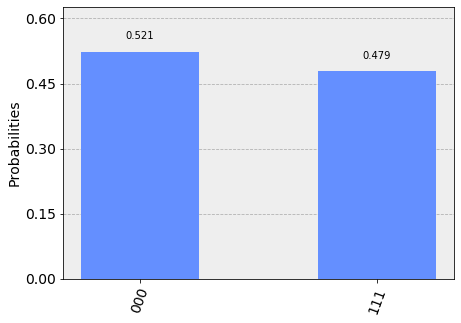

In [25]:
#Sim (3Pi/2)
MZ=MZI(q,qr,c,cr,x[6])
job_sim = execute(MZ, backend_sim, shots=sh)
result_sim=job_sim.result()
counts=result_sim.get_counts(MZ)
y_sim=np.append(y_sim,[counts['000']/sh])
plot_histogram(counts)

In [26]:
#exp (3Pi/2)
MZ_tp = transpile(MZ, backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4])
#job_exp= execute(MZ_tp, backend=backend_exp)
#job_exp.job_id()

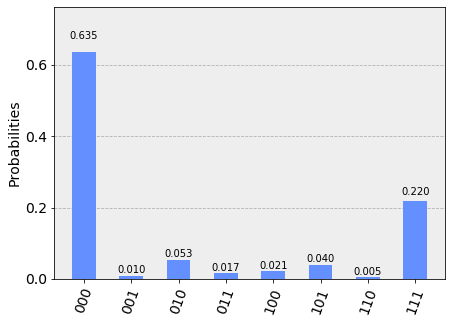

In [27]:
#exp (3Pi/2)
job_exp = backend_exp.retrieve_job('5e206c5734e104001814034f')
result_exp=job_exp.result()
counts=result_exp.get_counts()
y_exp=np.append(y_exp,[counts['000']/sh])
plot_histogram(counts)

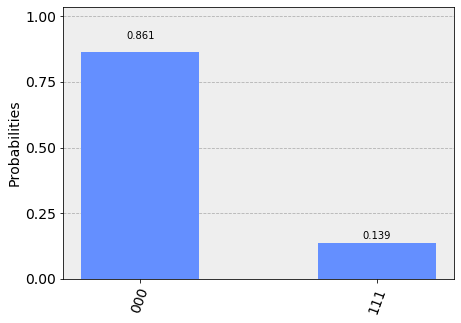

In [28]:
#Sim (7Pi/4)
MZ=MZI(q,qr,c,cr,x[7])
job_sim = execute(MZ, backend_sim, shots=sh)
result_sim=job_sim.result()
counts=result_sim.get_counts(MZ)
y_sim=np.append(y_sim,[counts['000']/sh])
plot_histogram(counts)

In [29]:
#exp (7Pi/4)
MZ_tp = transpile(MZ, backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4])
#job_exp= execute(MZ_tp, backend=backend_exp)
#job_exp.job_id()

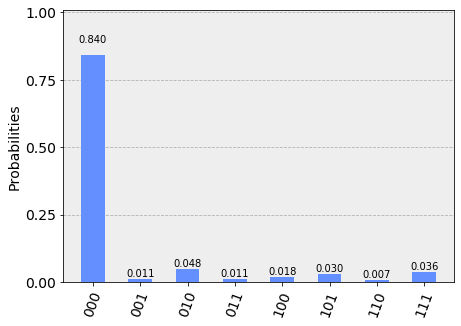

In [30]:
#exp (7Pi/4)
job_exp = backend_exp.retrieve_job('5e206c75c912c20018a84fef')
result_exp=job_exp.result()
counts=result_exp.get_counts()
y_exp=np.append(y_exp,[counts['000']/sh])
plot_histogram(counts)

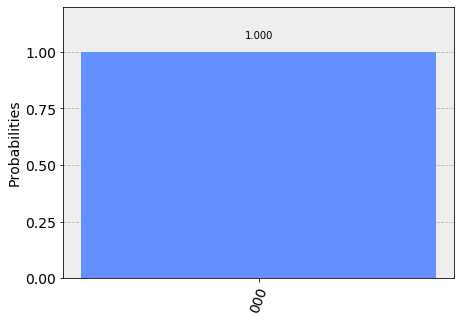

In [31]:
#Sim (2Pi)
MZ=MZI(q,qr,c,cr,x[8])
job_sim = execute(MZ, backend_sim, shots=sh)
result_sim=job_sim.result()
counts=result_sim.get_counts(MZ)
y_sim=np.append(y_sim,[counts['000']/sh])
plot_histogram(counts)

In [32]:
#exp (2Pi)
MZ_tp = transpile(MZ, backend=backend_exp, optimization_level=3, initial_layout=[2,0,1,3,4])
#job_exp= execute(MZ_tp, backend=backend_exp)
#job_exp.job_id()

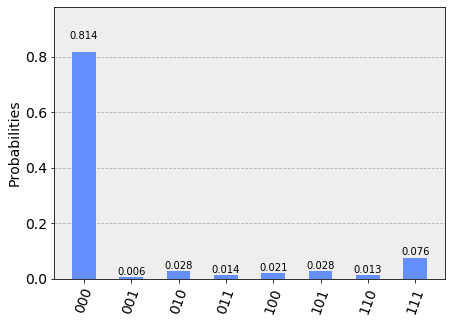

In [33]:
#exp (2Pi)
job_exp = backend_exp.retrieve_job('5e206c8fc77a86001805b90e')
result_exp=job_exp.result()
counts=result_exp.get_counts()
y_exp=np.append(y_exp,[counts['000']/sh])
plot_histogram(counts)

In [136]:
y_sim

array([1.        , 0.875     , 0.50390625, 0.14941406, 0.        ,
       0.15332031, 0.49804688, 0.86035156, 1.        , 0.8515625 ,
       0.48730469, 0.13183594, 0.        , 0.140625  , 0.47265625,
       0.82421875])

In [137]:
x

array([0.        , 0.26179939, 0.52359878, 0.78539816, 1.04719755,
       1.30899694, 1.57079633, 1.83259571, 2.0943951 , 2.35619449,
       2.61799388, 2.87979327, 3.14159265, 3.40339204, 3.66519143,
       3.92699082, 4.1887902 ])

In [119]:
y_exp

array([1.        , 0.86230469, 0.49511719, 0.15136719, 0.        ,
       0.14257812, 0.53417969, 0.85644531, 1.        , 0.875     ,
       0.48730469, 0.13476562, 0.        , 0.14550781, 0.49902344,
       0.8515625 , 1.        ])

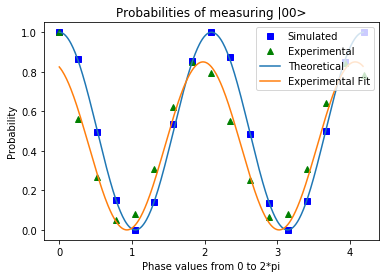

In [123]:
y_fit = 0.85*(np.cos((x_th*3)+(pi/9))+1)/2
x=np.arange(0,(16.5)*pi/(4*3),pi/(4*3))
plt.plot(x,y_sim,'bs',x,y_exp,'g^',x_th,y_th,x_th,y_fit)
plt.xlabel('Phase values from 0 to 2*pi') 
plt.ylabel('Probability')
plt.title('Probabilities of measuring |00>')
plt.legend(['Simulated', 'Experimental','Theoretical','Experimental Fit'],loc=1)     
plt.show()

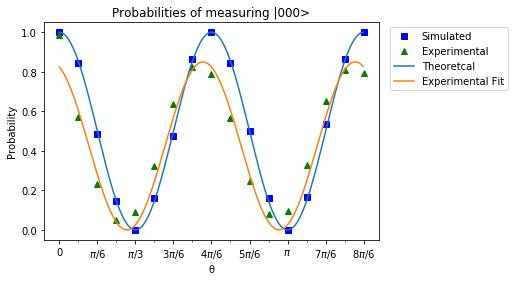

In [145]:
fig, ax = plt.subplots()
x_fit=np.arange(0,4*np.pi/6,0.01) 
y_fit = 0.85*(np.cos((x_th*3)+(pi/9))+1)/2
ax.plot(x,y_sim,'bs',x,y_exp,'g^',x_th,y_th,x_th,y_fit)
plt.xlabel('θ') 
plt.ylabel('Probability')
plt.title('Probabilities of measuring |000>')
plt.legend(['Simulated', 'Experimental','Theoretcal','Experimental Fit'],loc=1, bbox_to_anchor=(1.4,1))
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 6))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))

def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = int(np.round(6 * value / np.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/6$"
    elif N == 2:
        return r"$\pi/3$"
    elif N == 4:
        return r"$4\pi/6$"
    elif N== 6:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/6$".format(N)
    else:
        return r"${0}\pi/6$".format(N // 1)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

plt.show()
fig.savefig('MZ_3qubit_graph.pdf')

In [39]:
MZ_tp.draw()

AttributeError: 'NoneType' object has no attribute 'register'